In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocess_functions import load_data_relevant_cols
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
import keras

In [13]:
raw = load_data_relevant_cols()

/Users/Paul/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (4,6,8,10,11,12,17,18,24,29,31,33,35,37,38,39,41,43,45,46,47,49,51,53,54,55,57,58,59,60,61,62,63,64,73,76,79,82,84,86,88,90,92,94,96,97,106,108,114,115,121,123,125,126,127,128,129,134) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Paul/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (6,61,62,63,79,94,96,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
raw.columns

Index(['iyear', 'imonth', 'iday', 'country', 'country_txt', 'region',
       'region_txt', 'provstate', 'city', 'latitude', 'longitude',
       'specificity', 'success', 'attacktype1', 'attacktype1_txt', 'targtype1',
       'targtype1_txt', 'targsubtype1', 'targsubtype1_txt', 'natlty1',
       'natlty1_txt', 'gname', 'motive', 'weaptype1', 'weaptype1_txt',
       'weapsubtype1', 'weapsubtype1_txt', 'nkill', 'nkillus', 'nkillter',
       'nwound', 'nwoundus', 'nwoundte', 'property', 'propextent',
       'propextent_txt', 'propvalue', 'propcomment', 'ransom', 'ransomamt'],
      dtype='object')

### Lasso-CV to find predictors of success for terrorist attacks
X Variables used:
- attacktype1_txt dummies
- targtype1_txt dummies
- targsubtype1_txt dummies? 
- weaptype1_txt dummies
- weapsubtype1_txt dummies?

In [32]:
X = pd.get_dummies(raw.attacktype1_txt, prefix='attacktype')
X = X.join(pd.get_dummies(raw.targtype1_txt, prefix='targtype'))
X = X.join(pd.get_dummies(raw.targsubtype1_txt, prefix='targsubtype'))
X = X.join(pd.get_dummies(raw.weaptype1_txt, prefix='weaptype'))
X = X.join(pd.get_dummies(raw.weapsubtype1_txt, prefix='weapsubtype'))
Y = raw.success

- For prediction, predict for success
- If we want to cluster attacks, group by country or by terrorist group
- MDS
- 

In [71]:
wordbag = []
for motive_str in raw.motive.dropna():
    for word in motive_str.split():
        wordbag.append(word.lower().)

In [73]:
# pd.Series(wordbag).value_counts()

In [80]:
predictor = LassoCV(max_iter=10000, cv=5, verbose=True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [81]:
predictor.fit(X_train, y_train)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.2s finished


LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=True)

In [83]:
y_pred = predictor.predict(X_test)

In [95]:
fpr, tpr, thresh = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

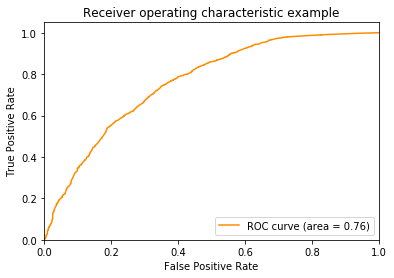

In [96]:
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [100]:
np.min(np.where(tpr > 0.9))

1502

In [110]:
fpr[1502]

0.55909090909090908

In [102]:
threshold = thresh[1502]

In [109]:
threshold

0.81834278691244589

In [105]:
rounded = []
for i in y_pred:
    if i > threshold:
        rounded.append(1)
    else:
        rounded.append(0)
rounded_y_pred = np.array(rounded)

In [106]:
confusion_matrix(y_test, rounded_y_pred)

array([[  777,   983],
       [ 1534, 13741]])

True Negatives: 777

False Negatives: 1534

True Positives: 13741

False Positives: 983

In [107]:
accuracy = (13741+777) / (13741 + 777 + 1534 + 983)

In [108]:
accuracy

0.852245377164661

In [113]:
raw.iyear = raw.iyear.astype('int')

raw.groupby(['iyear', 'attacktype1_txt']).count()['imonth']

# Neural Network

In [128]:
X_train.shape

(153315, 182)

In [143]:
model_tanh = Sequential()
model_tanh.add(Dense(units=10, activation='tanh', input_dim=182))
model_tanh.add(Dense(units=10, activation='tanh'))
model_tanh.add(Dense(units=1, activation='sigmoid'))

model_tanh.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_tanh = model_tanh.fit(X_train.values, y_train, epochs=25, batch_size=32, validation_data=(X_test.values, y_test))

Train on 153315 samples, validate on 17035 samples
Epoch 1/25
153315/153315 [==============================] - 12s - loss: 0.2811 - binary_accuracy: 0.9052 - val_loss: 0.2766 - val_binary_accuracy: 0.9066
Epoch 2/25
153315/153315 [==============================] - 12s - loss: 0.2731 - binary_accuracy: 0.9069 - val_loss: 0.2727 - val_binary_accuracy: 0.9070
Epoch 3/25
153315/153315 [==============================] - 12s - loss: 0.2706 - binary_accuracy: 0.9078 - val_loss: 0.2708 - val_binary_accuracy: 0.9082
Epoch 4/25
153315/153315 [==============================] - 12s - loss: 0.2688 - binary_accuracy: 0.9087 - val_loss: 0.2699 - val_binary_accuracy: 0.9088
Epoch 5/25
153315/153315 [==============================] - 12s - loss: 0.2675 - binary_accuracy: 0.9089 - val_loss: 0.2691 - val_binary_accuracy: 0.9095
Epoch 6/25
153315/153315 [==============================] - 12s - loss: 0.2665 - binary_accuracy: 0.9094 - val_loss: 0.2687 - val_binary_accuracy: 0.9090
Epoch 7/25
153315/153315 

In [144]:
model_relu = Sequential()
model_relu.add(Dense(units=10, activation='relu', input_dim=182))
model_relu.add(Dense(units=10, activation='relu'))
model_relu.add(Dense(units=1, activation='sigmoid'))

model_relu.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_relu = model_relu.fit(X_train.values, y_train, epochs=25, batch_size=32, validation_data=(X_test.values, y_test))

Train on 153315 samples, validate on 17035 samples
Epoch 1/25
153315/153315 [==============================] - 12s - loss: 0.2825 - binary_accuracy: 0.9032 - val_loss: 0.2740 - val_binary_accuracy: 0.9082
Epoch 2/25
153315/153315 [==============================] - 12s - loss: 0.2700 - binary_accuracy: 0.9090 - val_loss: 0.2708 - val_binary_accuracy: 0.9091
Epoch 3/25
153315/153315 [==============================] - 12s - loss: 0.2679 - binary_accuracy: 0.9094 - val_loss: 0.2702 - val_binary_accuracy: 0.9097
Epoch 4/25
153315/153315 [==============================] - 12s - loss: 0.2666 - binary_accuracy: 0.9096 - val_loss: 0.2697 - val_binary_accuracy: 0.9098
Epoch 5/25
153315/153315 [==============================] - 12s - loss: 0.2659 - binary_accuracy: 0.9098 - val_loss: 0.2691 - val_binary_accuracy: 0.9095
Epoch 6/25
153315/153315 [==============================] - 12s - loss: 0.2652 - binary_accuracy: 0.9098 - val_loss: 0.2689 - val_binary_accuracy: 0.9094
Epoch 7/25
153315/153315 

In [145]:
model_sigmoid = Sequential()
model_sigmoid.add(Dense(units=10, activation='sigmoid', input_dim=182))
model_sigmoid.add(Dense(units=10, activation='sigmoid'))
model_sigmoid.add(Dense(units=1, activation='sigmoid'))

model_sigmoid.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_sigmoid = model_sigmoid.fit(X_train.values, y_train, epochs=25, batch_size=32, validation_data=(X_test.values, y_test))

Train on 153315 samples, validate on 17035 samples
Epoch 1/25
153315/153315 [==============================] - 12s - loss: 0.2919 - binary_accuracy: 0.9001 - val_loss: 0.2773 - val_binary_accuracy: 0.9053
Epoch 2/25
153315/153315 [==============================] - 12s - loss: 0.2752 - binary_accuracy: 0.9056 - val_loss: 0.2758 - val_binary_accuracy: 0.9063
Epoch 3/25
153315/153315 [==============================] - 12s - loss: 0.2745 - binary_accuracy: 0.9063 - val_loss: 0.2755 - val_binary_accuracy: 0.9071
Epoch 4/25
153315/153315 [==============================] - 12s - loss: 0.2740 - binary_accuracy: 0.9068 - val_loss: 0.2751 - val_binary_accuracy: 0.9071
Epoch 5/25
153315/153315 [==============================] - 12s - loss: 0.2733 - binary_accuracy: 0.9069 - val_loss: 0.2741 - val_binary_accuracy: 0.9070
Epoch 6/25
153315/153315 [==============================] - 12s - loss: 0.2726 - binary_accuracy: 0.9070 - val_loss: 0.2738 - val_binary_accuracy: 0.9069
Epoch 7/25
153315/153315 

In [169]:
def plot_loss(history):
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['loss'], label='loss')
    plt.legend(loc='upper right')
    plt.show()
    
def plot_accuracy(history):
    plt.plot(history.history['val_binary_accuracy'], label='val_accuracy')
    plt.plot(history.history['binary_accuracy'], label='accuracy')
    plt.legend(loc='lower right')
    plt.show()

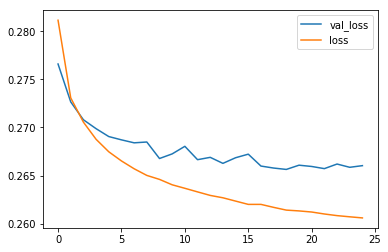

In [175]:
plot_loss(history_tanh)

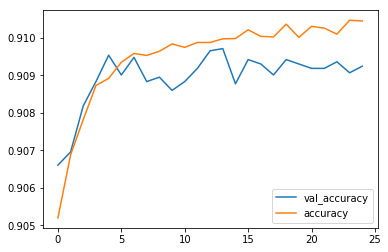

In [176]:
plot_accuracy(history_tanh)

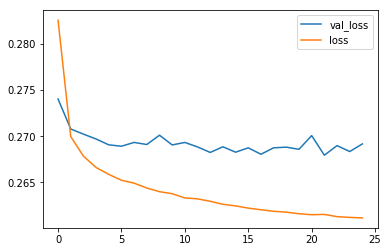

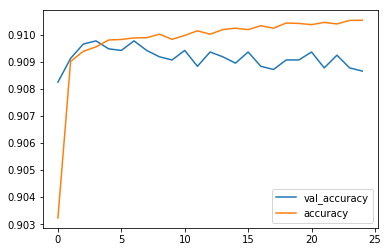

In [177]:
plot_loss(history_relu)
plot_accuracy(history_relu)

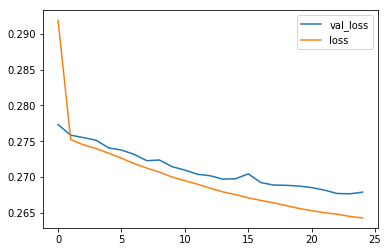

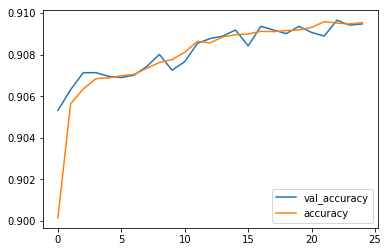

In [178]:
plot_loss(history_sigmoid)
plot_accuracy(history_sigmoid)

In [179]:
# More epochs for sigmoid training
history_sigmoid2 = model_sigmoid.fit(X_train.values, y_train, epochs=40, batch_size=32, initial_epoch=25, validation_data=(X_test.values, y_test))

Train on 153315 samples, validate on 17035 samples
Epoch 26/40
153315/153315 [==============================] - 12s - loss: 0.2640 - binary_accuracy: 0.9095 - val_loss: 0.2678 - val_binary_accuracy: 0.9095
Epoch 27/40
153315/153315 [==============================] - 12s - loss: 0.2638 - binary_accuracy: 0.9096 - val_loss: 0.2676 - val_binary_accuracy: 0.9100
Epoch 28/40
153315/153315 [==============================] - 11s - loss: 0.2636 - binary_accuracy: 0.9098 - val_loss: 0.2675 - val_binary_accuracy: 0.9097
Epoch 29/40
153315/153315 [==============================] - 11s - loss: 0.2635 - binary_accuracy: 0.9098 - val_loss: 0.2677 - val_binary_accuracy: 0.9094
Epoch 30/40
153315/153315 [==============================] - 12s - loss: 0.2634 - binary_accuracy: 0.9097 - val_loss: 0.2672 - val_binary_accuracy: 0.9095
Epoch 31/40
153315/153315 [==============================] - 13s - loss: 0.2632 - binary_accuracy: 0.9098 - val_loss: 0.2670 - val_binary_accuracy: 0.9097
Epoch 32/40
153315/

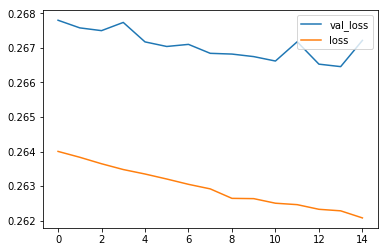

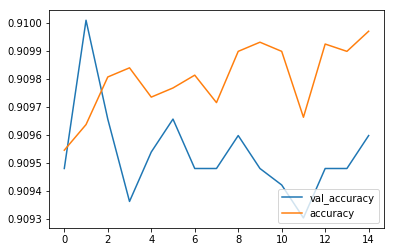

In [180]:
plot_loss(history_sigmoid2)
plot_accuracy(history_sigmoid2)

In [185]:
np.where(history_relu.history['val_binary_accuracy'] == max(history_relu.history['val_binary_accuracy']))

(array([3, 6]),)

In [186]:
np.where(history_tanh.history['val_binary_accuracy'] == max(history_tanh.history['val_binary_accuracy']))

(array([13]),)

In [187]:
max(history_relu.history['val_binary_accuracy'])

0.90977399473425435

In [188]:
max(history_tanh.history['val_binary_accuracy'])

0.90971529206328283

In [189]:
# Looks like tanh models with a few epochs are the way to go! Now lets try some different architectures
model_wide = Sequential()
model_wide.add(Dense(units=32, activation='tanh', input_dim=182))
model_wide.add(Dense(units=32, activation='tanh'))
model_wide.add(Dense(units=1, activation='sigmoid'))

model_wide.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_wide = model_wide.fit(X_train.values, y_train, epochs=10, batch_size=32, validation_data=(X_test.values, y_test))


Train on 153315 samples, validate on 17035 samples
Epoch 1/10
153315/153315 [==============================] - 13s - loss: 0.2792 - binary_accuracy: 0.9048 - val_loss: 0.2739 - val_binary_accuracy: 0.9070
Epoch 2/10
153315/153315 [==============================] - 13s - loss: 0.2721 - binary_accuracy: 0.9073 - val_loss: 0.2711 - val_binary_accuracy: 0.9081
Epoch 3/10
153315/153315 [==============================] - 13s - loss: 0.2692 - binary_accuracy: 0.9087 - val_loss: 0.2692 - val_binary_accuracy: 0.9091
Epoch 4/10
153315/153315 [==============================] - 13s - loss: 0.2672 - binary_accuracy: 0.9089 - val_loss: 0.2688 - val_binary_accuracy: 0.9088
Epoch 5/10
153315/153315 [==============================] - 12s - loss: 0.2661 - binary_accuracy: 0.9093 - val_loss: 0.2684 - val_binary_accuracy: 0.9092
Epoch 6/10
153315/153315 [==============================] - 12s - loss: 0.2652 - binary_accuracy: 0.9093 - val_loss: 0.2682 - val_binary_accuracy: 0.9095
Epoch 7/10
153315/153315 

In [190]:
# Looks like tanh models with a few epochs are the way to go! Now lets try some different architectures
model_wider = Sequential()
model_wider.add(Dense(units=64, activation='tanh', input_dim=182))
model_wider.add(Dense(units=64, activation='tanh'))
model_wider.add(Dense(units=1, activation='sigmoid'))

model_wider.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_wide = model_wider.fit(X_train.values, y_train, epochs=10, batch_size=32, validation_data=(X_test.values, y_test))


Train on 153315 samples, validate on 17035 samples
Epoch 1/10
153315/153315 [==============================] - 14s - loss: 0.2786 - binary_accuracy: 0.9048 - val_loss: 0.2738 - val_binary_accuracy: 0.9050
Epoch 2/10
153315/153315 [==============================] - 13s - loss: 0.2718 - binary_accuracy: 0.9079 - val_loss: 0.2717 - val_binary_accuracy: 0.9084
Epoch 3/10
153315/153315 [==============================] - 13s - loss: 0.2689 - binary_accuracy: 0.9088 - val_loss: 0.2702 - val_binary_accuracy: 0.9085
Epoch 4/10
153315/153315 [==============================] - 13s - loss: 0.2670 - binary_accuracy: 0.9091 - val_loss: 0.2690 - val_binary_accuracy: 0.9089
Epoch 5/10
153315/153315 [==============================] - 13s - loss: 0.2655 - binary_accuracy: 0.9095 - val_loss: 0.2682 - val_binary_accuracy: 0.9094
Epoch 6/10
153315/153315 [==============================] - 13s - loss: 0.2647 - binary_accuracy: 0.9095 - val_loss: 0.2675 - val_binary_accuracy: 0.9088
Epoch 7/10
153315/153315 

In [192]:
# Looks like tanh models with a few epochs are the way to go! Now lets try some different architectures
model_deep = Sequential()
model_deep.add(Dense(units=10, activation='tanh', input_dim=182))
model_deep.add(Dense(units=10, activation='tanh'))
model_deep.add(Dense(units=10, activation='tanh'))
model_deep.add(Dense(units=1, activation='sigmoid'))

model_deep.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_deep = model_deep.fit(X_train.values, y_train, epochs=15, batch_size=32, validation_data=(X_test.values, y_test))


Train on 153315 samples, validate on 17035 samples
Epoch 1/15
153315/153315 [==============================] - 15s - loss: 0.2811 - binary_accuracy: 0.9051 - val_loss: 0.2739 - val_binary_accuracy: 0.9075
Epoch 2/15
153315/153315 [==============================] - 14s - loss: 0.2721 - binary_accuracy: 0.9075 - val_loss: 0.2730 - val_binary_accuracy: 0.9080
Epoch 3/15
153315/153315 [==============================] - 14s - loss: 0.2702 - binary_accuracy: 0.9086 - val_loss: 0.2704 - val_binary_accuracy: 0.9092
Epoch 4/15
153315/153315 [==============================] - 15s - loss: 0.2687 - binary_accuracy: 0.9090 - val_loss: 0.2701 - val_binary_accuracy: 0.9092
Epoch 5/15
153315/153315 [==============================] - 13s - loss: 0.2677 - binary_accuracy: 0.9091 - val_loss: 0.2700 - val_binary_accuracy: 0.9091
Epoch 6/15
153315/153315 [==============================] - 12s - loss: 0.2670 - binary_accuracy: 0.9092 - val_loss: 0.2691 - val_binary_accuracy: 0.9094
Epoch 7/15
153315/153315 

In [193]:
model_big = Sequential()
model_big.add(Dense(units=32, activation='tanh', input_dim=182))
model_big.add(Dense(units=32, activation='tanh'))
model_big.add(Dense(units=32, activation='tanh'))
model_big.add(Dense(units=1, activation='sigmoid'))

model_big.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_big = model_deep.fit(X_train.values, y_train, epochs=20, batch_size=32, validation_data=(X_test.values, y_test))


Train on 153315 samples, validate on 17035 samples
Epoch 1/20
153315/153315 [==============================] - 13s - loss: 0.2627 - binary_accuracy: 0.9099 - val_loss: 0.2680 - val_binary_accuracy: 0.9101
Epoch 2/20
153315/153315 [==============================] - 13s - loss: 0.2624 - binary_accuracy: 0.9101 - val_loss: 0.2674 - val_binary_accuracy: 0.9094
Epoch 3/20
153315/153315 [==============================] - 13s - loss: 0.2621 - binary_accuracy: 0.9101 - val_loss: 0.2674 - val_binary_accuracy: 0.9094
Epoch 4/20
153315/153315 [==============================] - 14s - loss: 0.2621 - binary_accuracy: 0.9102 - val_loss: 0.2675 - val_binary_accuracy: 0.9092
Epoch 5/20
153315/153315 [==============================] - 15s - loss: 0.2619 - binary_accuracy: 0.9101 - val_loss: 0.2670 - val_binary_accuracy: 0.9092
Epoch 6/20
153315/153315 [==============================] - 15s - loss: 0.2616 - binary_accuracy: 0.9099 - val_loss: 0.2679 - val_binary_accuracy: 0.9092
Epoch 7/20
153315/153315 

In [195]:
# Looks like deep tanh models with a few epochs have steady losses! Now lets try some different architectures
from keras import regularizers
model_deep_l2 = Sequential()
model_deep_l2.add(Dense(units=10, activation='tanh', input_dim=182, kernel_regularizer=regularizers.l2(0.01)))
model_deep_l2.add(Dense(units=10, activation='tanh'))
model_deep_l2.add(Dense(units=10, activation='tanh'))
model_deep_l2.add(Dense(units=1, activation='sigmoid'))

model_deep_l2.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_deep_l2 = model_deep_l2.fit(X_train.values, y_train, epochs=15, batch_size=32, validation_data=(X_test.values, y_test))


Train on 153315 samples, validate on 17035 samples
Epoch 1/15
153315/153315 [==============================] - 15s - loss: 0.2946 - binary_accuracy: 0.9045 - val_loss: 0.2911 - val_binary_accuracy: 0.9063
Epoch 2/15
153315/153315 [==============================] - 15s - loss: 0.2832 - binary_accuracy: 0.9056 - val_loss: 0.2825 - val_binary_accuracy: 0.9031
Epoch 3/15
153315/153315 [==============================] - 15s - loss: 0.2813 - binary_accuracy: 0.9059 - val_loss: 0.2824 - val_binary_accuracy: 0.9067
Epoch 4/15
153315/153315 [==============================] - 15s - loss: 0.2802 - binary_accuracy: 0.9063 - val_loss: 0.2829 - val_binary_accuracy: 0.9035
Epoch 5/15
153315/153315 [==============================] - 15s - loss: 0.2798 - binary_accuracy: 0.9067 - val_loss: 0.2788 - val_binary_accuracy: 0.9074
Epoch 6/15
153315/153315 [==============================] - 15s - loss: 0.2794 - binary_accuracy: 0.9072 - val_loss: 0.2819 - val_binary_accuracy: 0.9070
Epoch 7/15
153315/153315 

In [196]:
# Looks like deep tanh models with a few epochs have steady losses! Now lets try some different architectures
from keras import regularizers
model_deep_l1 = Sequential()
model_deep_l1.add(Dense(units=10, activation='tanh', input_dim=182, kernel_regularizer=regularizers.l1(0.01)))
model_deep_l1.add(Dense(units=10, activation='tanh'))
model_deep_l1.add(Dense(units=10, activation='tanh'))
model_deep_l1.add(Dense(units=1, activation='sigmoid'))

model_deep_l1.compile(loss=keras.losses.binary_crossentropy, metrics=['binary_accuracy'],
              optimizer='adam')

history_deep_l1 = model_deep_l1.fit(X_train.values, y_train, epochs=15, batch_size=32, validation_data=(X_test.values, y_test))


Train on 153315 samples, validate on 17035 samples
Epoch 1/15
153315/153315 [==============================] - 15s - loss: 0.3349 - binary_accuracy: 0.9030 - val_loss: 0.3025 - val_binary_accuracy: 0.9024
Epoch 2/15
153315/153315 [==============================] - 14s - loss: 0.2994 - binary_accuracy: 0.9054 - val_loss: 0.2953 - val_binary_accuracy: 0.9038
Epoch 3/15
153315/153315 [==============================] - 14s - loss: 0.2969 - binary_accuracy: 0.9052 - val_loss: 0.2981 - val_binary_accuracy: 0.9011
Epoch 4/15
153315/153315 [==============================] - 14s - loss: 0.2966 - binary_accuracy: 0.9050 - val_loss: 0.2950 - val_binary_accuracy: 0.9065
Epoch 5/15
153315/153315 [==============================] - 14s - loss: 0.2966 - binary_accuracy: 0.9056 - val_loss: 0.2980 - val_binary_accuracy: 0.9016
Epoch 6/15
153315/153315 [==============================] - 14s - loss: 0.2965 - binary_accuracy: 0.9054 - val_loss: 0.2972 - val_binary_accuracy: 0.9036
Epoch 7/15
153315/153315 